<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Импортируем-библиотеки-и-функции,-используемые-в-проекте" data-toc-modified-id="Импортируем-библиотеки-и-функции,-используемые-в-проекте-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импортируем библиотеки и функции, используемые в проекте</a></span></li><li><span><a href="#Загрузка-и-предварительный-анализ-данных" data-toc-modified-id="Загрузка-и-предварительный-анализ-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузка и предварительный анализ данных</a></span></li></ul></li><li><span><a href="#Анализ-временного-ряда" data-toc-modified-id="Анализ-временного-ряда-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ временного ряда</a></span></li><li><span><a href="#Обучение-четырех-моделей" data-toc-modified-id="Обучение-четырех-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение четырех моделей</a></span></li><li><span><a href="#Тестирование-четрых-моделей" data-toc-modified-id="Тестирование-четрых-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование четрых моделей</a></span><ul class="toc-item"><li><span><a href="#Модель-«линейная-регрессия»" data-toc-modified-id="Модель-«линейная-регрессия»-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Модель «линейная регрессия»</a></span></li><li><span><a href="#Модель-«градиентный-бустинг»-библиотеки-XGBoost" data-toc-modified-id="Модель-«градиентный-бустинг»-библиотеки-XGBoost-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Модель «градиентный бустинг» библиотеки XGBoost</a></span></li><li><span><a href="#Модель-«градиентный-бустинг»-библиотеки-LightGBM" data-toc-modified-id="Модель-«градиентный-бустинг»-библиотеки-LightGBM-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Модель «градиентный бустинг» библиотеки LightGBM</a></span></li><li><span><a href="#Модель-«градиентный-бустинг»-библиотеки-CatBoost" data-toc-modified-id="Модель-«градиентный-бустинг»-библиотеки-CatBoost-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Модель «градиентный бустинг» библиотеки CatBoost</a></span></li><li><span><a href="#Таблица-значений-метрик-RMSE-моделей-на-тестовой-выборке" data-toc-modified-id="Таблица-значений-метрик-RMSE-моделей-на-тестовой-выборке-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Таблица значений метрик RMSE моделей на тестовой выборке</a></span></li></ul></li></ul></div>

#  Прогнозирование количества заказов такси - TaxiCity

В компании «TaxiCity» есть исторические данные о заказах такси за 6 месяцев в 2018 году. Чтобы обеспечивать удовлетворение спроса на услуги такси в периоды пиковой нагрузки, необходимо спрогнозировать количество заказов такси на следующий час.

Необходимо построить ML-модель для прогнозирования количества заказов.

Требования к ML-модели и данным:
1. Качество прогнозирования оценивать по метрике RMSE, значение метрики на тестовой выборке не должно превышать 48.
2. Размер тестовой выборки должен составлять 10% от исходных данных.

## Подготовка данных

### Импортируем библиотеки и функции, используемые в проекте

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math as mt
import numpy as np
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

### Загрузка и предварительный анализ данных

Прочитаем файл 'taxi.csv' и сохраним его в переменной df:

In [2]:
df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

Выполним ресемплирование данных по одному часу:

In [3]:
df = df.resample('1H').sum()

Выведем на экран: общую информацию и первые 5 строк таблицы df, состояние сортировки индексов (is_monotonic), числовое описание данных о кол-ве заказов:

In [4]:
df.info()
display(df.head())
print('\nIs_monotonic = ', df.index.is_monotonic)
print('\n', df.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43



Is_monotonic =  True

         num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000


**Вывод:**

Для проведения исследования представлен 1 csv-файл 'taxi.csv', который содержит таблицу с данными. В каждой строке таблицы - данные о заказах такси в аэропортах за указанный временной период. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

По результатам ресемплирования и предварительного анализа данных можно сделать следующие выводы:
1. В результате ресемплирования данных каждая строка таблицы df содержит данные о количестве заказов такси за один час.
2. Индексом таблицы df является столбец Datetime, индексы отсортированы по возрастанию, пропуски в данных отсутствуют, данные представлены за период с 2018-03-01 00:00:00 по 2018-08-31 23:00:00 (за 6 месяцев).
3. Среднее количество заказов такси за один час - 84, максимальное количество заказов за один час - 462.

## Анализ временного ряда

Декомпозируем временной ряд на три составляющие: тренд, сезонность и остаток:

In [5]:
decomposed = seasonal_decompose(df)

Рассчитаем скользящую среднюю для тренда:

In [6]:
df_trend = pd.DataFrame(decomposed.trend)
df_trend['rolling_mean'] = df_trend['trend'].rolling(120).mean()

Выведем на экран графики трех составляющих временного ряда: тренда со скользящей средней (Trend), сезонности (Seasonality) и остатка (Residuals):

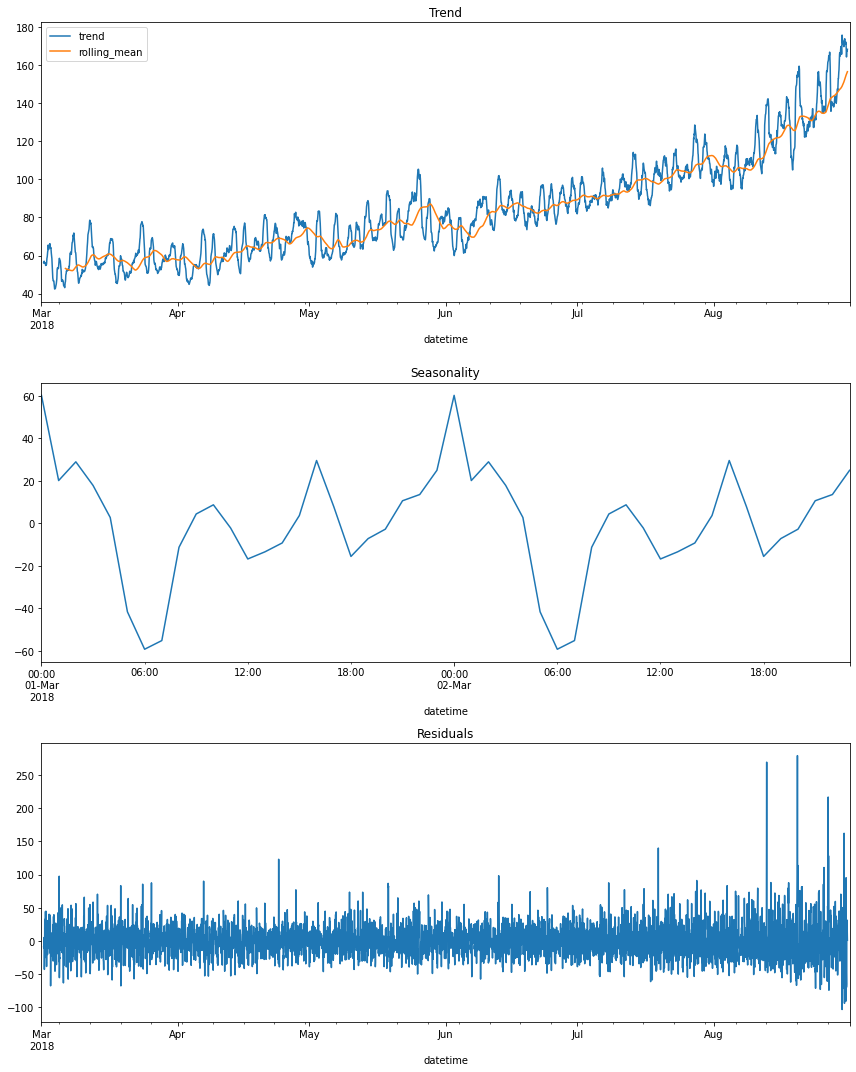

In [7]:
plt.figure(figsize=(12, 15))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его оси ax, равными plt.gca() (англ. get current axis, получить текущие оси)
df_trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal[0:48].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

**Вывод:**

В рамках декомпозиции временного ряда получили три набора данных, по результатам анализа которых можно сделать следующие выводы:
1. Тренд (англ. trend) — плавное изменение среднего значения ряда без повторяющихся закономерностей.<br>
Визуальный анализ графика тренда и скользящей средней говорят об увеличении количества заказов такси в течение 6 месяцев.
2. Сезонность (англ. seasonality) — циклично повторяющиеся закономерности во временном ряду.<br>
По графику сезонности можно выделить следующие закономерности, которые повторяются каждые сутки:<br>
с 00:00 до 06:00 - происходит снижение количества заказов такси;<br>
с 08:00 до 18:00 - среднее количество заказов такси;<br>
с 18:00 до 24:00 - происходит заметный рост количества заказов такси.
3. Остаток (англ. residuals) - это компонента, которая не объясняется трендом и сезонностью, это шум. 

## Обучение четырех моделей

Отключаем не критичные предупреждения:

In [8]:
warnings.filterwarnings('ignore')

Создадим функцию для получения признаков временного ряда, а также обучающей и тестовой выборок:

In [9]:
def f_make_features(fv_df_copy: pd.DataFrame, fv_target_colname: str, fv_max_lag: int, fv_rolling_mean_size: int):
    #функция для создания признаков временного ряда, а также обучающей и тестовой выборок

    #создадим календарные признаки временного ряда
    fv_df = fv_df_copy.copy()
    fv_df['year'] = fv_df.index.year
    fv_df['month'] = fv_df.index.month
    fv_df['day'] = fv_df.index.day
    fv_df['dayofweek'] = fv_df.index.dayofweek
    #создадим отстающие признаки временного ряда
    for lag in range(1, fv_max_lag + 1):
        fv_df['lag_{}'.format(lag)] = fv_df['num_orders'].shift(lag)
    #создадим признак временного ряда - скользящее среднее
    fv_df['rolling_mean'] = fv_df['num_orders'].shift().rolling(fv_rolling_mean_size).mean()

    #создадим обучающую (90%) и тестовую (10%) выборки
    fv_train, fv_test = train_test_split(fv_df, test_size=0.1, shuffle=False)
    #удалим строки с пропусками
    fv_train = fv_train.dropna()
    #разделим выборки на признаки и целевой признак
    fv_features_train = fv_train.drop(fv_target_colname, axis=1)
    fv_target_train = fv_train[fv_target_colname]
    fv_features_test = fv_test.drop(fv_target_colname, axis=1)
    fv_target_test = fv_test[fv_target_colname]

    return fv_features_train, fv_features_test, fv_target_train, fv_target_test

Создадим функцию для обучения одной из 4-х моделей («линейная регрессия», «градиентный бустинг» библиотек XGBoost, LightGBM и CatBoost), расчета метрики RMSE и оценки качества модели кросс-валидацией:

In [10]:
def f_4ML_models_rmse_cv(fv_features_train: pd.DataFrame, fv_target_train: pd.Series,
                         fv_modelname: str, fv_max_depth=None, fv_max_estimators=100, fv_learning_rate=1):
    #функция для обучения одной из 4-х моделей, расчета метрики RMSE и оценки качества модели кросс-валидацией

    #определим одну из 4-х моделей
    if fv_modelname == 'XGBRegressor':
        model = XGBRegressor(random_state=12345,
                             max_depth=fv_max_depth, n_estimators=fv_max_estimators, learning_rate=fv_learning_rate)
    elif fv_modelname == 'LGBMRegressor':
        model = LGBMRegressor(random_state=12345,
                              max_depth=fv_max_depth, n_estimators=fv_max_estimators, learning_rate=fv_learning_rate)
    elif fv_modelname == 'CatBoostRegressor':
        model = CatBoostRegressor(random_state=12345, loss_function="RMSE", 
                                  iterations=fv_max_estimators, depth=fv_max_depth, learning_rate=fv_learning_rate,
                                  verbose=False)
    else:
        model = LinearRegression()
    #вычислим метрику RMSE с использованием кросс-валидации
    scorer = make_scorer(mean_squared_error, greater_is_better=True)
    tscv = TimeSeriesSplit(n_splits=5)
    cv_rmse = mt.sqrt(cross_val_score(model, fv_features_train, fv_target_train, scoring=scorer, cv=tscv).mean())

    return cv_rmse

Для модели «линейная регрессия» определим значения параметров max_lag и rolling_mean_size для вычисления лучшего значения метрики RMSE:

In [11]:
for ml in range(160, 181, 10):
    for rms in range(10, 121, 10):
        features_train, features_test, target_train, target_test = f_make_features(df, 'num_orders', ml, rms)
        print('max_lag =', ml, ', rolling_mean_size =', rms, ', значение RMSE =',
              f_4ML_models_rmse_cv(features_train, target_train, 'LinearRegression'))

max_lag = 160 , rolling_mean_size = 10 , значение RMSE = 24.148622056465204
max_lag = 160 , rolling_mean_size = 20 , значение RMSE = 24.14926013072787
max_lag = 160 , rolling_mean_size = 30 , значение RMSE = 24.161276774744966
max_lag = 160 , rolling_mean_size = 40 , значение RMSE = 24.148343855042857
max_lag = 160 , rolling_mean_size = 50 , значение RMSE = 24.164672744769106
max_lag = 160 , rolling_mean_size = 60 , значение RMSE = 24.15753960772508
max_lag = 160 , rolling_mean_size = 70 , значение RMSE = 24.15493606343763
max_lag = 160 , rolling_mean_size = 80 , значение RMSE = 24.160101928649283
max_lag = 160 , rolling_mean_size = 90 , значение RMSE = 24.151279206107453
max_lag = 160 , rolling_mean_size = 100 , значение RMSE = 24.15381648672206
max_lag = 160 , rolling_mean_size = 110 , значение RMSE = 24.14766027646878
max_lag = 160 , rolling_mean_size = 120 , значение RMSE = 24.144227240882596
max_lag = 170 , rolling_mean_size = 10 , значение RMSE = 22.767827532430076
max_lag = 170 

Для модели «градиентный бустинг» библиотеки XGBoost определим значения параметра max_lag и гиперпараметра n_estimators для вычисления лучшего значения метрики RMSE:

In [12]:
for ml in range(160, 181, 10):
    for n_est in range(10, 31, 5):
        features_train, features_test, target_train, target_test = f_make_features(df, 'num_orders', ml, 20)
        print('max_lag =', ml, ', гиперпараметры n_estimators =', n_est,', max_depth = 1 , значение RMSE =',
              f_4ML_models_rmse_cv(features_train, target_train, 'XGBRegressor', 1, n_est))

max_lag = 160 , гиперпараметры n_estimators = 10 , max_depth = 1 , значение RMSE = 27.810424944946867
max_lag = 160 , гиперпараметры n_estimators = 15 , max_depth = 1 , значение RMSE = 27.030465338627106
max_lag = 160 , гиперпараметры n_estimators = 20 , max_depth = 1 , значение RMSE = 26.76134357059028
max_lag = 160 , гиперпараметры n_estimators = 25 , max_depth = 1 , значение RMSE = 26.709861865048662
max_lag = 160 , гиперпараметры n_estimators = 30 , max_depth = 1 , значение RMSE = 26.549304780046693
max_lag = 170 , гиперпараметры n_estimators = 10 , max_depth = 1 , значение RMSE = 25.37354123090092
max_lag = 170 , гиперпараметры n_estimators = 15 , max_depth = 1 , значение RMSE = 25.092850121064277
max_lag = 170 , гиперпараметры n_estimators = 20 , max_depth = 1 , значение RMSE = 24.87164991851257
max_lag = 170 , гиперпараметры n_estimators = 25 , max_depth = 1 , значение RMSE = 24.903028681667852
max_lag = 170 , гиперпараметры n_estimators = 30 , max_depth = 1 , значение RMSE = 25

Для модели «градиентный бустинг» библиотеки LightGBM определим значения параметра max_lag и гиперпараметра n_estimators для вычисления лучшего значения метрики RMSE:

In [13]:
for ml in range(220, 241, 10):
    for n_est in range(20, 41, 5):
        features_train, features_test, target_train, target_test = f_make_features(df, 'num_orders', ml, 20)
        print('max_lag =', ml, ', гиперпараметры n_estimators =', n_est,', max_depth = 1 , значение RMSE =',
              f_4ML_models_rmse_cv(features_train, target_train, 'LGBMRegressor', 1, n_est))

max_lag = 220 , гиперпараметры n_estimators = 20 , max_depth = 1 , значение RMSE = 24.597094806575978
max_lag = 220 , гиперпараметры n_estimators = 25 , max_depth = 1 , значение RMSE = 24.597300044686673
max_lag = 220 , гиперпараметры n_estimators = 30 , max_depth = 1 , значение RMSE = 24.73033158628343
max_lag = 220 , гиперпараметры n_estimators = 35 , max_depth = 1 , значение RMSE = 24.738059294799395
max_lag = 220 , гиперпараметры n_estimators = 40 , max_depth = 1 , значение RMSE = 24.760861407049738
max_lag = 230 , гиперпараметры n_estimators = 20 , max_depth = 1 , значение RMSE = 24.714733033651452
max_lag = 230 , гиперпараметры n_estimators = 25 , max_depth = 1 , значение RMSE = 24.547108091777336
max_lag = 230 , гиперпараметры n_estimators = 30 , max_depth = 1 , значение RMSE = 24.528428618406892
max_lag = 230 , гиперпараметры n_estimators = 35 , max_depth = 1 , значение RMSE = 24.554797966871067
max_lag = 230 , гиперпараметры n_estimators = 40 , max_depth = 1 , значение RMSE = 

Для модели «градиентный бустинг» библиотеки CatBoost определим значения параметра max_lag и гиперпараметра iterations для вычисления лучшего значения метрики RMSE:

In [14]:
for ml in range(210, 231, 10):
    for n_est in range(30, 51, 5):
        features_train, features_test, target_train, target_test = f_make_features(df, 'num_orders', ml, 20)
        print('max_lag =', ml, ', гиперпараметры iterations =', n_est,', depth = 1 , значение RMSE =',
              f_4ML_models_rmse_cv(features_train, target_train, 'CatBoostRegressor', 1, n_est))

max_lag = 210 , гиперпараметры iterations = 30 , depth = 1 , значение RMSE = 25.216221344679965
max_lag = 210 , гиперпараметры iterations = 35 , depth = 1 , значение RMSE = 25.311276857645673
max_lag = 210 , гиперпараметры iterations = 40 , depth = 1 , значение RMSE = 25.46226345956355
max_lag = 210 , гиперпараметры iterations = 45 , depth = 1 , значение RMSE = 25.494738900830605
max_lag = 210 , гиперпараметры iterations = 50 , depth = 1 , значение RMSE = 25.389979179367693
max_lag = 220 , гиперпараметры iterations = 30 , depth = 1 , значение RMSE = 25.17777301283947
max_lag = 220 , гиперпараметры iterations = 35 , depth = 1 , значение RMSE = 25.202202861249358
max_lag = 220 , гиперпараметры iterations = 40 , depth = 1 , значение RMSE = 24.8752930566454
max_lag = 220 , гиперпараметры iterations = 45 , depth = 1 , значение RMSE = 24.894327327120603
max_lag = 220 , гиперпараметры iterations = 50 , depth = 1 , значение RMSE = 24.96479904045015
max_lag = 230 , гиперпараметры iterations = 3

## Тестирование четрых моделей

Создадим функцию для обучения одной из 4-х моделей («линейная регрессия», «градиентный бустинг» библиотек XGBoost, LightGBM и CatBoost), расчета метрик RMSE модели и констатной модели, а также для подготовки данных для построения графика важности признаков модели:

In [15]:
def f_4ML_models_rmse(fv_df: pd.DataFrame, df_rmse: pd.DataFrame, fv_max_lag: int, fv_rolling_mean_size: int,
                      fv_modelname: str, fv_max_estimators=70, fv_max_depth=1, fv_learning_rate=1):
    #функция для обучения и расчета метрики RMSE одной из 4-х моделей

    #создадим обучающую и тестовую выборки для временного ряда
    features_train, features_test, target_train, target_test = f_make_features(fv_df, 'num_orders',
                                                                               fv_max_lag, fv_rolling_mean_size)
    #определим одну из 4-х моделей
    if fv_modelname == 'XGBRegressor':
        model = XGBRegressor(random_state=12345,
                             max_depth=fv_max_depth, n_estimators=fv_max_estimators, learning_rate=fv_learning_rate)
    elif fv_modelname == 'LGBMRegressor':
        model = LGBMRegressor(random_state=12345,
                              max_depth=fv_max_depth, n_estimators=fv_max_estimators, learning_rate=fv_learning_rate)
    elif fv_modelname == 'CatBoostRegressor':
        model = CatBoostRegressor(random_state=12345, loss_function="RMSE", 
                                  iterations=fv_max_estimators, depth=fv_max_depth, learning_rate=fv_learning_rate)
    else:
        model = LinearRegression()
    #обучим модель
    if fv_modelname == 'CatBoostRegressor':
        model.fit(features_train, target_train, verbose=300)
    else:
        model.fit(features_train, target_train)
    #вычислим метрику RMSE
    predict_test = model.predict(features_test)
    rmse = mt.sqrt(mean_squared_error(target_test, predict_test))
    #вычислим метрику RMSE константной модели
    dr = DummyRegressor(strategy='median')
    dr.fit(features_train, target_train)
    rmse_cm = mt.sqrt(mean_squared_error(target_test, dr.predict(features_test)))
    #сохраним значения RMSE для модели и константной модели
    df_rmse.loc[df_rmse['Модель']==fv_modelname, 'RMSE модели'] = rmse
    df_rmse.loc[df_rmse['Модель']==fv_modelname, 'RMSE константной модели'] = rmse_cm
    #подготовим данные для построения графика важности признаков модели
    if fv_modelname in ('XGBRegressor', 'LGBMRegressor', 'CatBoostRegressor'):
        feature_importance = model.feature_importances_
    else:
        feature_importance = model.coef_
    feature_imp = pd.DataFrame(sorted(zip(feature_importance, features_train)), columns=['Value','Feature'])
    #подготовим данные для построения графика исходного и предсказанного рядов
    df_target_test = pd.DataFrame(target_test)
    df_target_test.columns=['исходный ряд']
    df_target_test['предсказанный ряд'] = predict_test

    return rmse, rmse_cm, feature_imp, df_target_test

Создадим датафрейм df_rmse для хранения значений метрик RMSE четырех моделей:

In [16]:
df_rmse = pd.DataFrame(data=[['LinearRegression', np.nan, np.nan],
                             ['XGBRegressor', np.nan, np.nan],
                             ['LGBMRegressor', np.nan, np.nan],
                             ['CatBoostRegressor', np.nan, np.nan]],
                       columns=['Модель', 'RMSE модели', 'RMSE константной модели'])

### Модель «линейная регрессия»

Вычислим значение метрик RMSE модели и констатной модели для тестовой выборки, а также построим график важности признаков модели и график исходного и предсказанного рядов:

RMSE модели LinearRegression = 35.7311540063903 
RMSE константной модели = 86.41465855206327


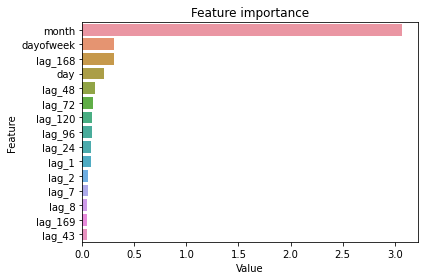

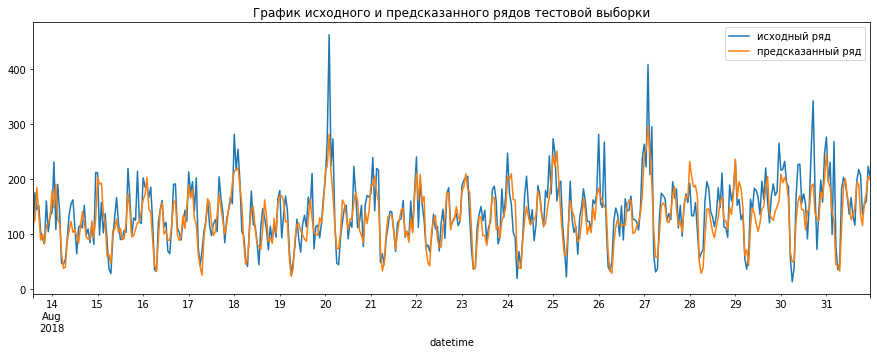

In [17]:
rmse, rmse_cm, feature_imp, df_target_test = f_4ML_models_rmse(df, df_rmse, 170, 20, 'LinearRegression')
print('RMSE модели LinearRegression =', rmse, '\nRMSE константной модели =', rmse_cm)
#Построим график важности признаков модели
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:15])
plt.title('Feature importance')
plt.tight_layout()
plt.show();
#Построим график исходного и предсказанного рядов тестовой выборки
df_target_test.plot(title='График исходного и предсказанного рядов тестовой выборки', figsize=(15, 5))
plt.show()

### Модель «градиентный бустинг» библиотеки XGBoost

Вычислим значение метрик RMSE модели и констатной модели для тестовой выборки, а также построим график важности признаков модели и график исходного и предсказанного рядов:

RMSE модели XGBRegressor = 42.3408916618551 
RMSE константной модели = 86.41465855206327


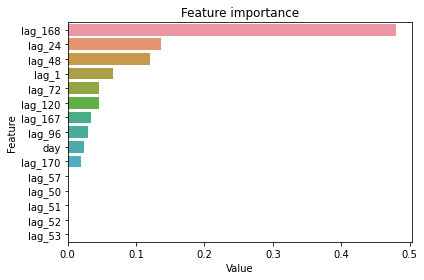

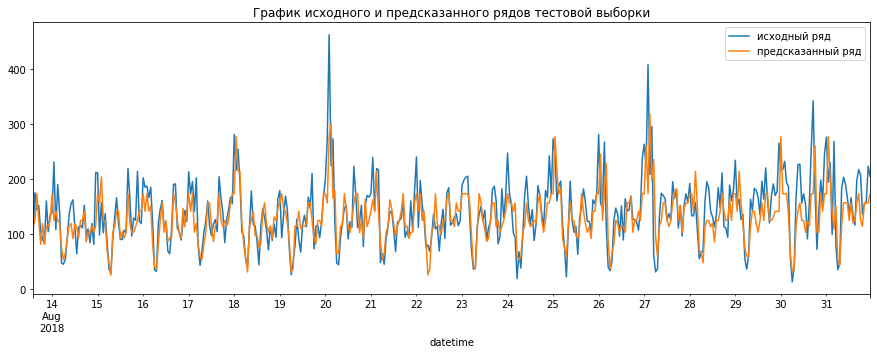

In [18]:
rmse, rmse_cm, feature_imp, df_target_test = f_4ML_models_rmse(df, df_rmse, 170, 20, 'XGBRegressor', 20)
print('RMSE модели XGBRegressor =', rmse, '\nRMSE константной модели =', rmse_cm)
#Построим график важности признаков модели
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:15])
plt.title('Feature importance')
plt.tight_layout()
plt.show();
#Построим график исходного и предсказанного рядов тестовой выборки
df_target_test.plot(title='График исходного и предсказанного рядов тестовой выборки', figsize=(15, 5))
plt.show()

### Модель «градиентный бустинг» библиотеки LightGBM

Вычислим значение метрик RMSE модели и констатной модели для тестовой выборки, а также построим график важности признаков модели и график исходного и предсказанного рядов:

RMSE модели LGBMRegressor = 40.34235467153566 
RMSE константной модели = 86.41465855206327


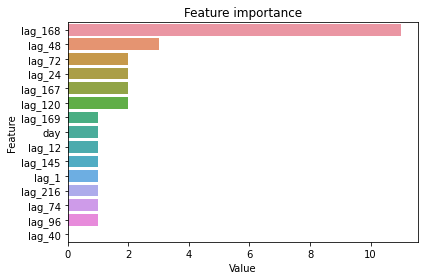

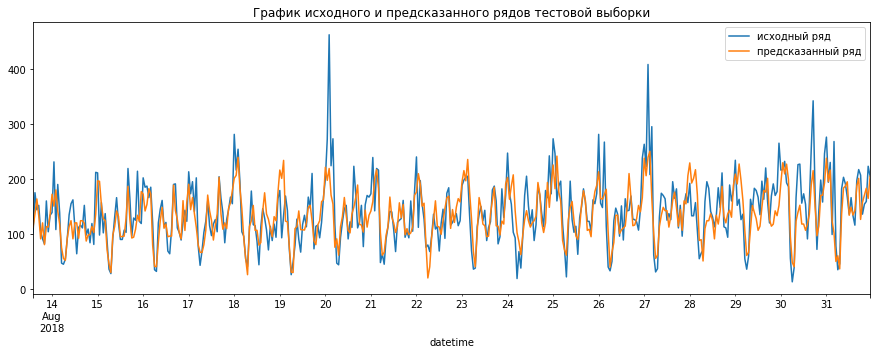

In [19]:
rmse, rmse_cm, feature_imp, df_target_test = f_4ML_models_rmse(df, df_rmse, 230, 20, 'LGBMRegressor', 30)
print('RMSE модели LGBMRegressor =', rmse, '\nRMSE константной модели =', rmse_cm)
#Построим график важности признаков модели
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:15])
plt.title('Feature importance')
plt.tight_layout()
plt.show();
#Построим график исходного и предсказанного рядов тестовой выборки
df_target_test.plot(title='График исходного и предсказанного рядов тестовой выборки', figsize=(15, 5))
plt.show()

### Модель «градиентный бустинг» библиотеки CatBoost

Вычислим значение метрик RMSE модели и констатной модели для тестовой выборки, а также построим график важности признаков модели и график исходного и предсказанного рядов:

0:	learn: 30.6611620	total: 5.64ms	remaining: 220ms
39:	learn: 20.9457683	total: 187ms	remaining: 0us
RMSE модели CatBoostRegressor = 41.49915524572722 
RMSE константной модели = 86.41465855206327


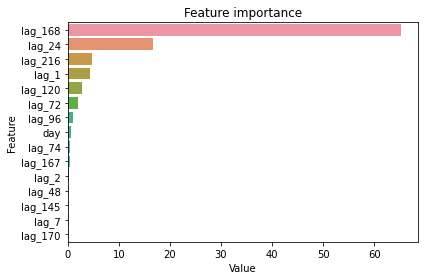

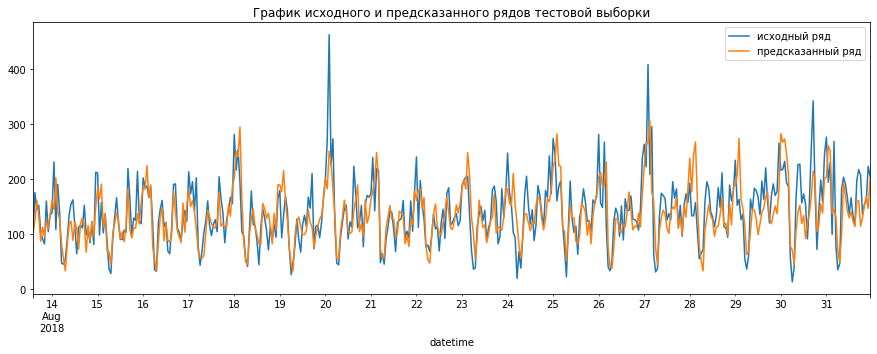

In [20]:
rmse, rmse_cm, feature_imp, df_target_test = f_4ML_models_rmse(df, df_rmse, 220, 20, 'CatBoostRegressor', 40)
print('RMSE модели CatBoostRegressor =', rmse, '\nRMSE константной модели =', rmse_cm)
#Построим график кажности признаков модели
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:15])
plt.title('Feature importance')
plt.tight_layout()
plt.show();
#Построим график исходного и предсказанного рядов тестовой выборки
df_target_test.plot(title='График исходного и предсказанного рядов тестовой выборки', figsize=(15, 5))
plt.show()

### Таблица значений метрик RMSE моделей на тестовой выборке

In [21]:
df_rmse.head()

,Модель,RMSE модели,RMSE константной модели
0,LinearRegression,35.731154,86.414659
1,XGBRegressor,42.340892,86.414659
2,LGBMRegressor,40.342355,86.414659
3,CatBoostRegressor,41.499155,86.414659


**Вывод:**

По результатам проекта можно сделать следующие выводы:
1. Лучшей ML-моделью для прогнозирования количества заказов такси на следующий час является «линейная регрессия», значение метрики RMSE на тестовой выборке = 35.7 (лучшее качество предсказания по сравнению с другими ML-моделями), что соответствует условиям проекта (значение метрики RMSE на тестовой выборке должно быть не больше 48).
2. Значения метрик RMSE на тестовой выборке для моделей градиентного бустинга библиотек XGBoost, LightGBM и CatBoost также соответствуют условиям проекта (менее 48), но хуже, чем у модели «линейная регрессия».
3. Стоит отметить, что наиболее важными факторами (признаками) для прогноза количества заказов такси являются месяц, день недели (только для линейной регрессии) и отстающие признаки временного ряда (для всех моделей).
4. Все ML-модели осуществляют прогноз лучше, чем константная модель (RMSE = 86). Поэтому, применение указанных ML-моделей является оправданным для бизнеса.